# YOLO on TensorFlow

This notebook aims to create a trainable and usable version of YOLO on TensorFlow.

In [1]:
# *** IMPORT ***
import tensorflow as tf
from tf_yolo_utils import *   # fcts. to create custom layers

# Import kitti_utils from a different project
import sys
sys.path.insert(0, '/data2/lucas/Projects/Kitti2012')
from kitti_utils import *    # fcts. to manage the kitti dataset

In [2]:
print_labels(import_labels(700, 'train'))

----------------------------------------------------------------------
|type            |  y_min     |  x_min     |  y_max     |  x_max     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Car             |  176.1     |  581.85    |  190.53    |  600.06    |
----------------------------------------------------------------------
|Car             |  183.14    |  292.06    |  243.71    |  399.96    |
----------------------------------------------------------------------
|DontCare        |  166.69    |  559.56    |  188.61    |  576.27    |
----------------------------------------------------------------------
|DontCare        |  162.52    |  574.15    |  177.15    |  603.36    |
----------------------------------------------------------------------
|DontCare        |  161.48    |  609.56    |  175.06    |  624.18    |
----------------------------------------------------------------------


## The YOLO Architecture
![The YOLO Architecture](doc_img/YOLO_architecture.png)

The YOLO Detection network has 24 convolutional layers followed by 2 fully connected layers.

The predictions are encoded as an S x S x (B * 5 + C) tensor where S x S is the size of the grid that divides the input images. B is the number of boxes in one cell grid, C the number of conditional class probabilites.

N.B. __IoU (Intersection over Union)__ is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.

![Intersection over Union Illustration](doc_img/iou_equation+examples.png)
_Source:[pyimagesearch.com](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)_ 

In [3]:
# --- HYPERPARAMETERS ---
TRAIN_PERC = 60   # Percentage of the data to put in the training set
DEV_PERC = 20     # Percentage of the data to put in the dev set
TEST_PERC = 20    # Percentage of the data to put in the test set

SEED = 42         # Seed used to randomize the dataset

BATCH_SIZE = 50   # Size of a batch of data
STEPS = 5000      # Number of step to train the CNN

IM_SIZE = 448     # 448=7*64  (Original shape of the image=(375, 1242, 3))
S = 7             # S x S grid the image is divided into
B = 2             # B = number of boxes per cell grid
C = 9             # C = number of labelled classes

# --- IMPORT DATA ---
ids_for_training = get_data_list('train')
train_batches_ids, dev_batches_ids, test_batches_ids = prepare_dataset(ids_for_training, [TRAIN_PERC, DEV_PERC, TEST_PERC], BATCH_SIZE, SEED)

# --- IMPORT BATCH ---
# Function to import the images in the batches and to format the labels
# - TODO -

# --- DEFINE CNN ---
x = tf.placeholder(tf.float32, shape=[None, IM_SIZE, IM_SIZE, 3])
y = tf.placeholder(tf.float32, shape=[None, S * S * (B * 5 + C)])

# --- CONV. LAYER 1 ---
# 7x7x64-s-2
# Maxpool: 2x2-s-2

conv1 = conv_layer(x, shape=[7, 7, 3, 64], strides=[1,2,2,1])
conv1_pool = max_pool_2x2(conv1)

# --- CONV. LAYER 2 ---
# 3x3x192
# Maxpool: 2x2-s-2

conv2 = conv_layer(conv1_pool, shape=[3, 3, 64, 192], strides=[1,2,2,1])
conv2_pool = max_pool_2x2(conv2)

# --- CONV. LAYERS 3 ---
# 1x1x128
# 3x3x256
# 1x1x256
# 3x3x512
# Maxpool: 2x2-s-2

conv3_1 = conv_layer(conv2_pool, shape=[1, 1, 192, 128])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, 128, 256])
conv3_3 = conv_layer(conv3_2, shape=[1, 1, 256, 256])
conv3_4 = conv_layer(conv3_3, shape=[3, 3, 256, 512])
conv3_pool = max_pool_2x2(conv3_4)

# --- CONV. LAYERS 4 ---
# 1x1x256  ____ x4
# 3x3x512  _|
# 1x1x512
# 3x3x1024
# Maxpool: 2x2-s-2

conv4_1 = conv_layer(conv3_pool, shape=[1, 1, 512, 256])
conv4_2 = conv_layer(conv4_1, shape=[3, 3, 256, 512])

conv4_3 = conv_layer(conv4_2, shape=[1, 1, 512, 256])
conv4_4 = conv_layer(conv4_3, shape=[3, 3, 256, 512])

conv4_5 = conv_layer(conv4_4, shape=[1, 1, 512, 256])
conv4_6 = conv_layer(conv4_5, shape=[3, 3, 256, 512])

conv4_7 = conv_layer(conv4_6, shape=[1, 1, 512, 256])
conv4_8 = conv_layer(conv4_7, shape=[3, 3, 256, 512])

conv4_9 = conv_layer(conv4_8, shape=[1, 1, 512, 512])
conv4_10 = conv_layer(conv4_9, shape=[3, 3, 512, 1024])

conv4_pool = max_pool_2x2(conv4_10)

# --- CONV. LAYERS 5 ---
# 1x1x512   ____ x2
# 3x3x1024  _|
# 3x3x1024
# 3x3x1024-s-2

conv5_1 = conv_layer(conv4_pool, shape=[1, 1, 1024, 512])
conv5_2 = conv_layer(conv5_1, shape=[3, 3, 512, 1024])

conv5_3 = conv_layer(conv5_2, shape=[1, 1, 1024, 512])
conv5_4 = conv_layer(conv5_3, shape=[3, 3, 512, 1024])

conv5_5 = conv_layer(conv5_4, shape=[3, 3, 1024, 1024])

conv5_6 = conv_layer(conv5_5, shape=[3, 3, 1024, 1024], strides=[1, 2, 2, 1])

# --- CONV. LAYERS 6 ---
# 3x3x1024
# 3x3x1024

conv6_1 = conv_layer(conv5_6, shape=[3, 3, 1024, 1024])
conv6_2 = conv_layer(conv6_1, shape=[3, 3, 1024, 1024])

# --- FULL LAYER 1 ---
# 4096

conv6_2_flatten = tf.reshape(conv6_2, [-1, 16 * 1024]) # Got it to 16*1024 to have only one l ouput per image

full_1_ = full_layer(conv6_2_flatten, 4096)
full_1 = tf.maximum(full_1_, 0.1 * full_1_)  # Leaky ReLU

full_1_drop = tf.nn.dropout(full_1, keep_prob=0.5)

# --- FULL LAYER 2 ---

full_2 = full_layer(full_1_drop, S * S * (B * 5 + C))


In [4]:
# try to get an image run through the CNN
# import image
im_1_ = import_im(111, 'train')
im_1_ = misc.imresize(im_1_, (IM_SIZE, IM_SIZE, 3))
im_1 = im_1_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_2_ = import_im(222, 'train')
im_2_ = misc.imresize(im_2_, (IM_SIZE, IM_SIZE, 3))
im_2 = im_2_.reshape([-1, IM_SIZE, IM_SIZE, 3])

ims = np.concatenate((im_1, im_2),axis=0)

print(ims.shape)

# initialize variables
sess = tf.Session()

sess.run(tf.global_variables_initializer())

result = sess.run(full_2, feed_dict = {x: ims})

result.shape

(2, 448, 448, 3)


(2, 931)

In [16]:
# Create Labels
labels = import_labels(0, 'train')

# Import image for reference
image = import_im(0, 'train')
im_width = image.shape[1]
im_height = image.shape[0]

cell_width = im_width / S
cell_height = im_height / S

# Create the empty numpy array to contain all the labels
arr_labels = np.zeros((1, S * S * (B * 5 + C)))

for label in labels:
    
    # Extract from Paper:
    # "Each bounding box consists of 5 predictions: x, y, w, h,
    # and confidence. The (x, y) coordinates represent the center
    # of the box relative to the bounds of the grid cell. The width
    # and height are predicted relative to the whole image."

    # Width and Height of the box in pixel size
    box_width = label['bbox']['x_max'] - label['bbox']['x_min']  
    box_height = label['bbox']['y_max'] - label['bbox']['y_min']
    
    # Normalize the width and height of the box
    box_width_norm = box_width / im_width
    box_height_norm = box_height / im_height
    
    # Center of the box in pixel coordinates
    x_center = (label['bbox']['x_min'] + (box_width/2))
    y_center = (label['bbox']['y_min'] + (box_height/2))
    
    # Coordinates of the cell the center of the object is in (from 0 to ...)
    x_cell = math.floor(x_center / im_width * S)
    y_cell = math.floor(y_center / im_height * S)
    
    # Coordinates of the center of the box relative to the box
    box_center_x_norm = (x_center - x_cell * cell_width) / cell_width
    box_center_y_norm = (y_center - y_cell * cell_height) / cell_height
    
    box_IoU = 1   # As it is the ground truth
    
    box_info = [box_center_x_norm, box_center_y_norm,
                box_width_norm, box_height_norm, box_IoU]
    
    # Class Probabilities
    list_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
    
    class_proba = np.zeros(len(list_classes))
    
    index_class = list_classes.index(label['type'])
    
    class_proba[index_class] = 1
    
    # Add the label to the array of labels (horizontal line put one after the other as in the CNN)
    # Check if the cell is empty
    index_start_cell = y_cell * S * (B * 5 + C) + x_cell * (B * 5 + C)
    
    # Extract the class probabilities of the grid cell
    cell_class_proba = arr_labels[:, (index_start_cell + B * 5):(index_start_cell + B * 5) + C]
    
    # If the cell is empty
    #if sum(cell_class_proba) == 0:
        

    print(box_info)
    print(x_center, y_center)
    print(x_cell * cell_width, y_cell * cell_height)
    print(x_cell, y_cell)
    print(cell_width, cell_height)

[0.35535539215686296, 0.26545945945945987, 0.08033496732026148, 0.4457297297297298, 1]
761.565 225.46
699.4285714285714 211.42857142857142
4 4
174.85714285714286 52.857142857142854


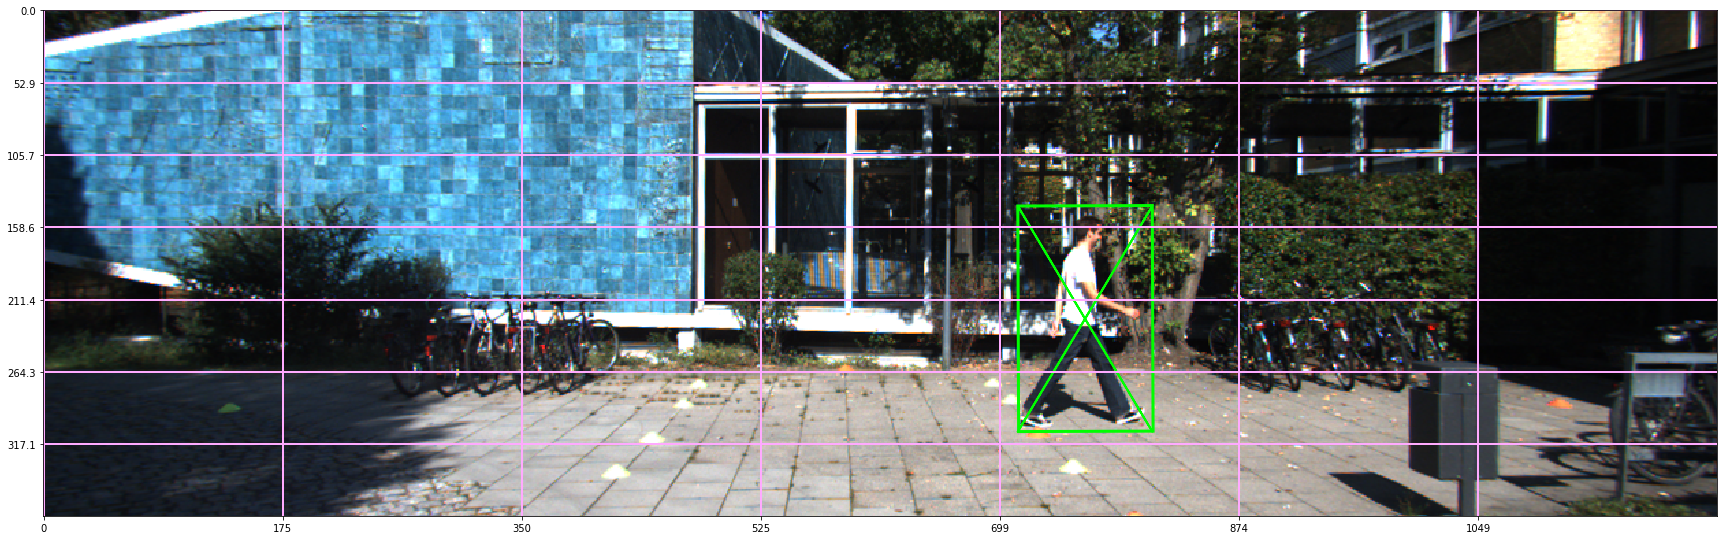

----------------------------------------------------------------------
|type            |  y_min     |  x_min     |  y_max     |  x_max     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Pedestrian      |  143.0     |  712.4     |  307.92    |  810.73    |
----------------------------------------------------------------------


In [15]:
display_im(image, labels, display_axis=True, num_cell_grid = 7)

## Loss Function
![The YOLO Loss Function](doc_img/YOLO_loss_function.png)